### Treefalls basic statistical analysis

The document descibes natural disturbances in stands caused by winds. We are trying to estimate the amount of such disturbances using different numerical measures, such as area of disturbances vs. geomorphological variables (height above sea level, slope, aspect, local gaussian curvature. 

### Configuration parameters

The section defines parameters that will allow to get access to the data: DEM and DEM-derived data, treefalls masked arrays.

In [3]:
import os
datadir = './data'
data_mapper = {'kunashir': {'box' : [4838720, 4935728, 369720, 468775], 
                            'data': {'height': 'kunUTM.tif',
                                     'curvature': 'vars_kun/Curvatu_kun.tif',
                                     'slope': 'vars_kun/Slope_kun.tif',
                                     'aspect': 'vars_kun/Aspect_kun.tif',
                                     'treefall': 'tiff_windfalls/windfalls_500m2_sakh_kur_Pol1.tif',
                                     'cover': 'forest_cover.tif'
                                    }
                                    },
               'sakhalin': {'box': [5086970, 5377762, 85000, 243321],
                            'data': {'height': 'sakhUTM.tif',
                            'curvature': 'vars_sakh/Curvatu.tif',
                            'slope': 'vars_sakh/Slope.tif',
                            'aspect': 'vars_sakh/Aspect.tif',
                            'treefall': 'tiff_windfalls/windfalls_500m2_sakh_kur_Pol1.tif',
                            'cover': 'forest_cover.tif'
                                    }},
               'iturup': {'box': [4915354, 5004258, 488455, 556985],
                          'data':   {'height': 'kunUTM.tif',
                                     'curvature': 'vars_kun/Curvatu_kun.tif',
                                     'slope': 'vars_kun/Slope_kun.tif',
                                     'aspect': 'vars_kun/Aspect_kun.tif',
                                     'treefall': 'tiff_windfalls/windfalls_500m2_sakh_kur_Pol1.tif',
                                     'cover': 'forest_cover.tif'
                                    }}
               } 

for key in data_mapper:
    for j in data_mapper[key]['data']:
        data_mapper[key]['data'][j] = os.path.join(datadir, data_mapper[key]['data'][j])


### Auxiliary functions

Here we define `gdal` based function used to perform basic i/o operations on spatial data. 

In [4]:
import numpy as np
from osgeo import gdal
from osgeo import osr

def array_to_raster(array, lats, lons,  outputfilename, asfname):
    """Array > Raster
    Save a raster from a C order array.

    :param array: ndarray
    """
    
    SourceDS = gdal.Open(asfname, gdal.GA_ReadOnly)
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())    
    x_pixels, y_pixels = array.shape
    XPIXEL_SIZE = (lons[1] - lons[0]) / float(x_pixels)
    YPIXEL_SIZE = (lats[1] - lats[0]) / float(y_pixels)
    x_min = np.min(lons)
    y_max = np.max(lats)
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(
        outputfilename,
        y_pixels,
        x_pixels,
        1,
        gdal.GDT_Float32)

    dataset.SetGeoTransform((
        x_min,    # 0
        abs(XPIXEL_SIZE),  # 1
        0,                      # 2
        y_max,    # 3
        0,                      # 4
        -abs(YPIXEL_SIZE)))
    dataset.SetProjection(Projection.ExportToWkt())
    dataset.GetRasterBand(1).WriteArray(array)
    dataset.FlushCache()  # Write to disk.
    return 0


def get_data_by_coordinate_np(lats, lons, array, xmin, xres, ymax, yres):
    """Just a helper function"""
    lat_inds = ((lats - ymax) / yres).astype(np.int16)
    lon_inds = ((lons - xmin) / xres).astype(np.int16)
    array = array[lat_inds, lon_inds]
    return array


def load_data(lats, lons, filename):
    data = gdal.Open(filename)
    geoinfo = data.GetGeoTransform()
    xmin = geoinfo[0]
    xres = geoinfo[1]
    ymax = geoinfo[3]
    yrot = geoinfo[4]
    xrot = geoinfo[2]
    yres = geoinfo[-1]
    if not np.isclose(xrot, 0) or not np.isclose(yrot, 0):
        raise BaseException("xrot and yrot should be 0")
    array = data.ReadAsArray()
    del data
    result = get_data_by_coordinate_np(np.array(lats, dtype=np.float64),
                                  np.array(lons, dtype=np.float64),
                                  array,
                                  xmin, xres, ymax, yres)
    return result


def create_grid(area, dlat=50, dlon=50):
    """Returns raw meshgrid based on specified discretization parameters
    """
    latmin, latmax, lonmin, lonmax = area
    lats = np.arange(latmin, latmax, dlat)
    lons = np.arange(lonmin, lonmax, dlon)
    return np.meshgrid(lats, lons)



### Functions for specific data loading

In [5]:
def load_specific_data(area='sakhalin', spec='treefall', dlat=50, dlon=50):
    """Loads data and return flattened array"""
    lats, lons = create_grid(data_mapper[area]['box'], dlat=dlat, dlon=dlon)
    data = load_data(lats, lons, data_mapper[area]['data'][spec])
    if spec == 'treefall':
        nodata_value = 255
        data[data==nodata_value] = 0
    return data, lats, lons
  

## Lets do some tests

In [6]:
import matplotlib.pyplot as plt

Explored area:  sakhalin
(3167, 5816) (3167, 5816) (3167, 5816)


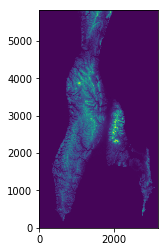

Explored area:  kunashir
(1982, 1941) (1982, 1941) (1982, 1941)


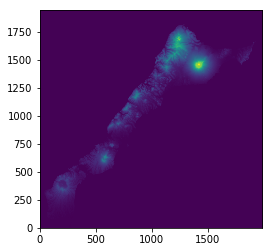

Explored area:  iturup
(1371, 1779) (1371, 1779) (1371, 1779)


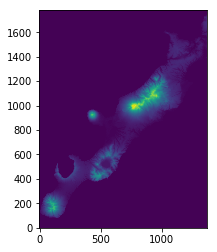

In [7]:
for area in data_mapper:
    print("Explored area: ", area)
    data, lats, lons = load_specific_data(area=area, spec='height')
    print(data.shape, lats.shape, lons.shape)
    plt.imshow(data.T, origin='lower')
    plt.show()

All tests are passed: we are ready to continue... 

### Area estimations, w/wo slope corrections

In [8]:
for area in data_mapper:
    print("========= {} ==============".format(area))
    slopes, lats, lons = load_specific_data(area=area, spec='slope')
    treefall, lats, lons = load_specific_data(area=area, spec='treefall')
    lat_size, lon_size = abs(lats[0][1] - lats[0][0]), abs(lons[1][0] - lons[0][0])
    print("Total area is sq. km: ", ((lat_size * lon_size)/np.cos(slopes[treefall == 1]/180*np.pi)).sum()/10**6)
    print("Total area w/o slope correction, sq. km: ", (lat_size * lon_size*(treefall == 1).sum())/10**6)
    print("=" * 50)
    
    

========= sakhalin ==============
Total area is sq. km:  447.50576
Total area w/o slope correction, sq. km:  426.4
========= kunashir ==============
Total area is sq. km:  11.191938
Total area w/o slope correction, sq. km:  10.95
========= iturup ==============
Total area is sq. km:  9.540099
Total area w/o slope correction, sq. km:  9.4975


### Treefalls diagram vs. relief characteristics

========= sakhalin ==============


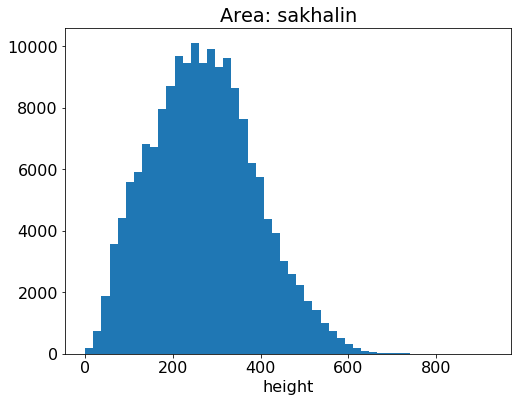

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.27142249530058393, pvalue=0.0)


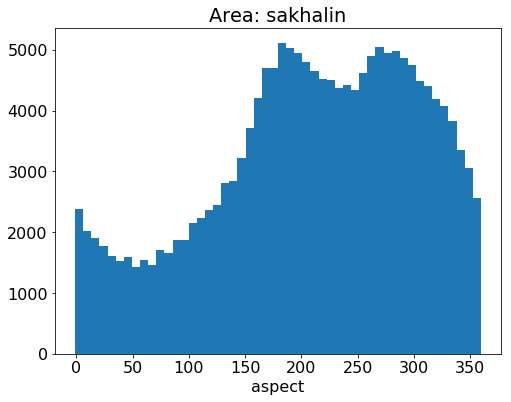

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.15975631745783886, pvalue=0.0)


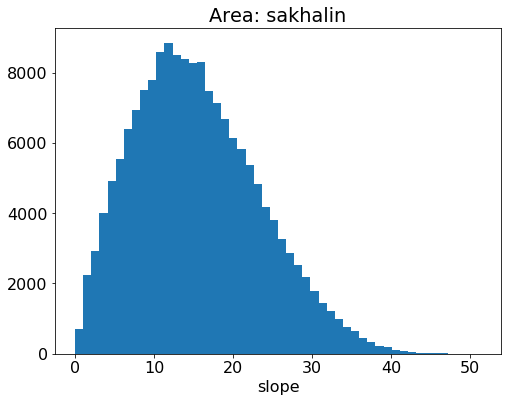

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.12063617342687424, pvalue=0.0)


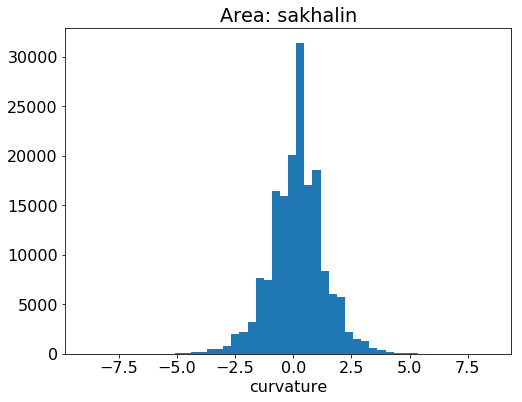

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.10073799951881535, pvalue=0.0)
========= kunashir ==============


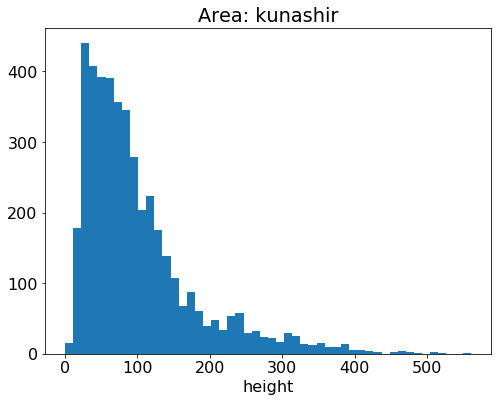

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.3187088824148921, pvalue=0.0)


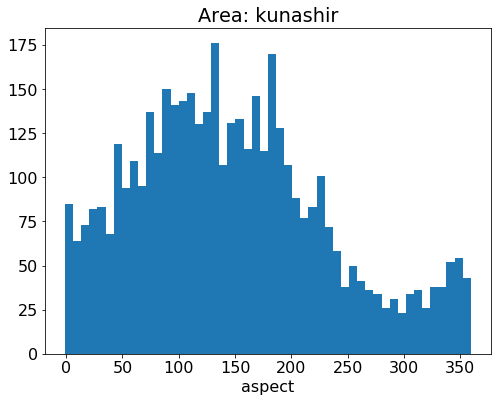

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.16301008696809427, pvalue=5.4351342620335704e-101)


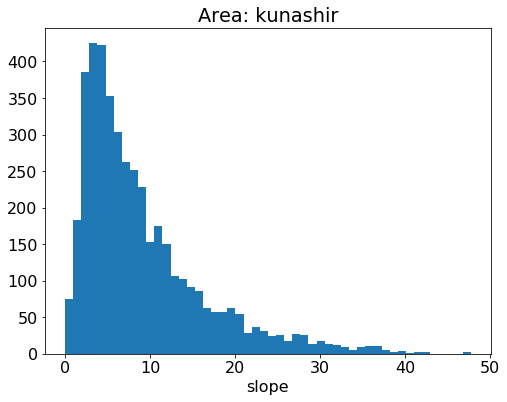

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.14668605982701854, pvalue=7.383723134198279e-82)


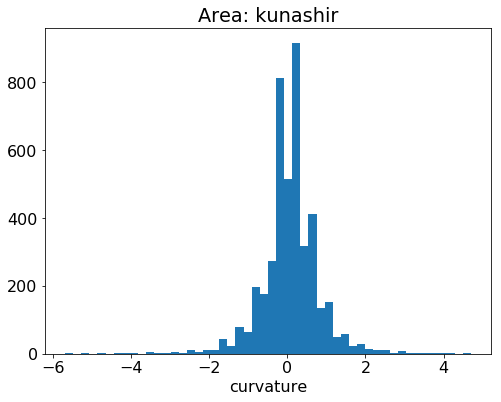

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.06056720391982237, pvalue=2.6158275947338786e-14)
========= iturup ==============


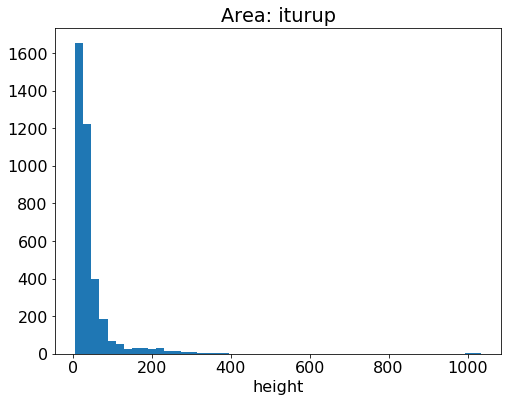

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.6510321496454823, pvalue=0.0)


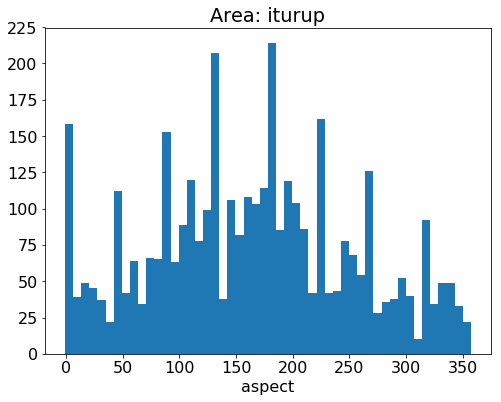

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.11128602401809373, pvalue=4.596700630262272e-41)


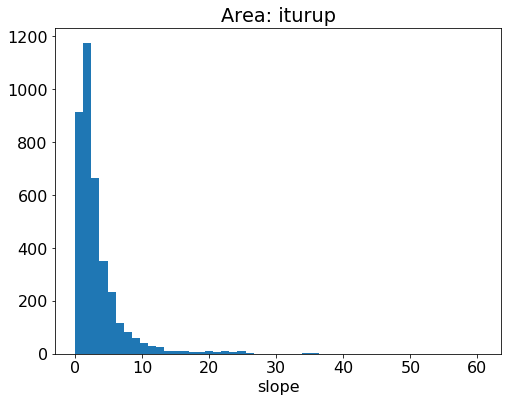

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.4685188125298584, pvalue=0.0)


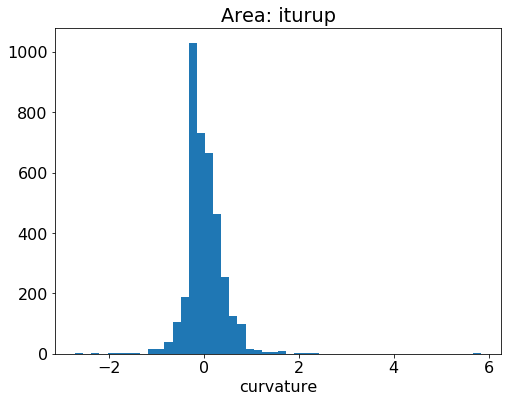

Statistical comparison to all points
K-S test:  Ks_2sampResult(statistic=0.13942812805075944, pvalue=3.2375888993744276e-64)


In [9]:
from scipy.stats import ks_2samp
plt.rcParams.update({'font.size': 16})
for area in data_mapper:
    print("========= {} ==============".format(area))
    treefall, lats, lons = load_specific_data(area=area, spec='treefall')
    cover, lats, lons = load_specific_data(area=area, spec='cover')
    aspect, lats, lons = load_specific_data(area=area, spec='aspect')
    for var in ('height', 'aspect', 'slope', 'curvature'):
        data, lats, lons = load_specific_data(area=area, spec=var)
        plt.figure(figsize=(8, 6))
        plt.hist(data[treefall == 1], bins=50)
        plt.title("Area: {}".format(area))
        plt.gca().set_xlabel(str(var))
        plt.show()
        print("Statistical comparison to all points")
        all_data_indicies = ((aspect != -1) & (cover > 25)).ravel()
        tree_fall_indicies = (treefall == 1).ravel()
        print("K-S test: ", ks_2samp(data.ravel()[tree_fall_indicies], data.ravel()[all_data_indicies]))
        print("=" * 50)


### Linear discrimintation analysis

========= sakhalin ==============
ROC_AUC: mean=0.680870788516826, std=0.1308955246969097
Accuracy: mean=0.49991046634062447, std=0.0002608499174365056


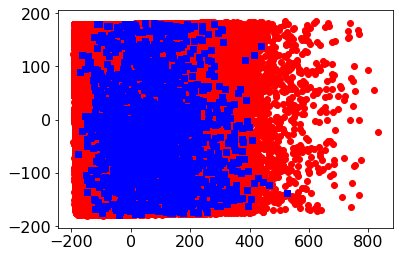

========= kunashir ==============
ROC_AUC: mean=0.6363997074212415, std=0.18373579267218837
Accuracy: mean=0.5, std=0.0


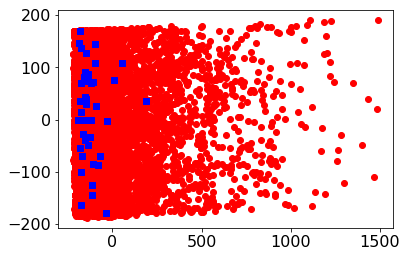

========= iturup ==============
ROC_AUC: mean=0.8334759140023179, std=0.12911801247212956
Accuracy: mean=0.5, std=0.0


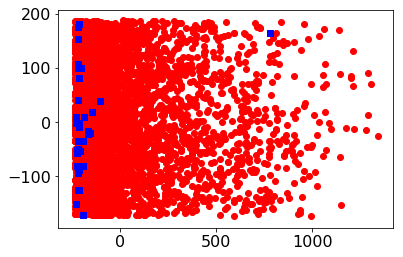

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA

for area in data_mapper:
    print("========= {} ==============".format(area))
    treefall, lats, lons = load_specific_data(area=area, spec='treefall')
    data, lats, lons = load_specific_data(area=area, spec='aspect')
    non_tree_fall_indicies = ((treefall != 1 ) & (data != -1)).ravel()
    tree_fall_indicies = (treefall == 1).ravel()
    # accumulate dataset 
    X = []
    y = np.hstack([[0] * non_tree_fall_indicies.sum(), [1] * tree_fall_indicies.sum()])
    for var in ('height', 'aspect', 'slope', 'curvature'):
        data, lats, lons = load_specific_data(area=area, spec=var)
        _ = np.hstack([data.ravel()[non_tree_fall_indicies], data.ravel()[tree_fall_indicies]])
        X.append(_.tolist())
    X = np.array(X).T
    model = LinearDiscriminantAnalysis().fit(X, y)
    roc_auc = cross_val_score(model, X, y, cv=10, scoring='roc_auc')
    print("ROC_AUC: mean={}, std={}".format(np.mean(roc_auc),np.std(roc_auc)))
    accuracy = cross_val_score(model, X, y, cv=10, scoring='balanced_accuracy')
    print("Accuracy: mean={}, std={}".format(np.mean(accuracy),np.std(accuracy)))
    
    # Performing PCA projections
    _, X_, _, y_ = train_test_split(X, y, stratify=y, test_size=0.01, random_state=0)
    X_proj = PCA(n_components=2).fit_transform(X_)
    plt.scatter(X_proj[y_==0, 0], X_proj[y_==0, 1], marker='o', color='r')
    plt.scatter(X_proj[y_==1, 0], X_proj[y_==1, 1], marker='s', color='b')
    plt.show()
    print("=" * 50)

## Conclusion: it is too hard to get any assesemnet on tree falling incidents based on considered geomorphological variables. 